In [1]:
"""
Purpose: To run the soma splitting 
on the processed neurons

"""


'\nPurpose: To run the soma splitting \non the processed neurons\n\n'

In [2]:
import numpy as np
import datajoint as dj
import trimesh
from tqdm.notebook import tqdm
from pathlib import Path

from os import sys
sys.path.append("/meshAfterParty/")

from importlib import reload

In [3]:
import datajoint_utils as du

INFO - 2021-01-22 19:09:10,391 - settings - Setting database.host to at-database.ad.bcm.edu
INFO - 2021-01-22 19:09:10,392 - settings - Setting database.user to celiib
INFO - 2021-01-22 19:09:10,393 - settings - Setting database.password to newceliipass
INFO - 2021-01-22 19:09:10,397 - settings - Setting stores to {'minnie65': {'protocol': 'file', 'location': '/mnt/dj-stor01/platinum/minnie65', 'stage': '/mnt/dj-stor01/platinum/minnie65'}, 'meshes': {'protocol': 'file', 'location': '/mnt/dj-stor01/platinum/minnie65/02/meshes', 'stage': '/mnt/dj-stor01/platinum/minnie65/02/meshes'}, 'decimated_meshes': {'protocol': 'file', 'location': '/mnt/dj-stor01/platinum/minnie65/02/decimated_meshes', 'stage': '/mnt/dj-stor01/platinum/minnie65/02/decimated_meshes'}, 'skeletons': {'protocol': 'file', 'location': '/mnt/dj-stor01/platinum/minnie65/02/skeletons'}}
INFO - 2021-01-22 19:09:10,399 - settings - Setting enable_python_native_blobs to True
INFO - 2021-01-22 19:09:10,414 - connection - Connect

Connecting celiib@at-database.ad.bcm.edu:3306


INFO - 2021-01-22 19:09:10,660 - settings - Setting enable_python_native_blobs to True


In [4]:
test_mode = True

In [5]:
import minfig
import time
import numpy as np
#want to add in a wait for the connection part
random_sleep_sec = np.random.randint(0, 200)
print(f"Sleeping {random_sleep_sec} sec before conneting")
if not test_mode:
    time.sleep(random_sleep_sec)
print("Done sleeping")

du.config_celii()
du.set_minnie65_config_segmentation(minfig)
du.print_minnie65_config_paths(minfig)

#configuring will include the adapters
minnie,schema = du.configure_minnie_vm()

INFO - 2021-01-22 19:09:10,691 - settings - Setting database.host to at-database.ad.bcm.edu
INFO - 2021-01-22 19:09:10,692 - settings - Setting database.user to celiib
INFO - 2021-01-22 19:09:10,693 - settings - Setting database.password to newceliipass
INFO - 2021-01-22 19:09:10,694 - settings - Setting enable_python_native_blobs to True


Sleeping 198 sec before conneting
Done sleeping
Current path for external_segmentation_path = /mnt/dj-stor01/platinum/minnie65/02
Current path for external_mesh_path = /mnt/dj-stor01/platinum/minnie65/02/meshes
Current path for external_decimated_mesh_path = /mnt/dj-stor01/platinum/minnie65/02/decimated_meshes
Current path for external_skeleton_path = /mnt/dj-stor01/platinum/minnie65/02/skeletons


INFO - 2021-01-22 19:09:10,956 - settings - Setting enable_python_native_blobs to True


# Defining the Table

In [6]:
import neuron_utils as nru
import neuron
import trimesh_utils as tu
import numpy as np

In [7]:
import meshlab
meshlab.set_meshlab_port(current_port=None)

No port chosen so picked random port 4846


In [8]:
#so that it will have the adapter defined
from datajoint_utils import *

In [9]:
import numpy as np
import time
import proofreading_utils as pru

@schema
class NeuronSplitSuggestions(dj.Computed):
    definition="""
    -> minnie.Decomposition
    ---
    split_results: longblob #will store the results of how to split the limbs of neuron objects
    run_time=NULL : double                   # the amount of time to run (seconds)

    """

#     key_source = minnie.Decomposition() & minnie.MultiSomaProofread2.proj()
    classified_table = minnie.BaylorManualCellType() & 'nucleus_version=3'
    key_source = (minnie.Decomposition()  & classified_table.proj())
    key_source
    
    def make(self,key):
        """
        Pseudocode for process:

        1) Fetch the neuron object
        2) Run the mutli-split suggestions
        3) Calculate the total time
        4) Write the results to the table
        """
        whole_pass_time = time.time()
        #1) Get the segment id from the key
        segment_id = key["segment_id"]
        print(f"\n\n----- Working on Neuron {segment_id}-------")
        
        neuron_obj = (minnie.Decomposition & key).fetch1("decomposition")
        
        limb_results = pru.multi_soma_split_suggestions(neuron_obj,plot_intermediates=False)
        
        #7) Pass stats and file location to insert
        new_key = dict(key,
                       split_results = limb_results,
                       run_time=np.round(time.time() - whole_pass_time,4)
                      )

        self.insert1(new_key, allow_direct_insert=True, skip_duplicates=True)

        print(f"\n\n ------ Total time for Splitting {segment_id} = {time.time() - whole_pass_time} ------")
    

# Running the Populate

In [10]:
curr_table = (minnie.schema.jobs & "table_name='__neuron_split_suggestions'")
(curr_table)#.delete()# & "status='error'")
#curr_table.delete()
#(curr_table & "error_message = 'ValueError: need at least one array to concatenate'").delete()

table_name className of the table,key_hash key hash,"status if tuple is missing, the job is available",key structure containing the key,error_message error message returned if failed,error_stack error stack if failed,user database user,host system hostname,pid system process id,connection_id connection_id(),timestamp automatic timestamp
__neuron_split_suggestions,5c14dfc89c7bc3140ae04da3e3669d52,reserved,=BLOB=,,=BLOB=,celiib@10.21.18.111,71caefafdeec,17876,66167,2021-01-22 13:09:01


INFO - 2021-01-22 19:09:11,075 - autopopulate - Found 165 keys to populate
INFO - 2021-01-22 19:09:11,083 - connection - Transaction started
INFO - 2021-01-22 19:09:11,085 - autopopulate - Populating: {'segment_id': 864691136293271959, 'decimation_version': 0, 'decimation_ratio': Decimal('0.25'), 'ver': Decimal('30.00'), 'process_version': 3, 'index': 0}


Populate Started


----- Working on Neuron 864691136293271959-------
Decompressing Neuron in minimal output mode...please wait
multi_soma_limbs = []
multi_touch_limbs = []


 ------ Total time for Splitting 864691136293271959 = 25.776312828063965 ------


----- Working on Neuron 864691136296658203-------
Decompressing Neuron in minimal output mode...please wait
multi_soma_limbs = []
multi_touch_limbs = []


 ------ Total time for Splitting 864691136296658203 = 19.763572692871094 ------


----- Working on Neuron 864691136289538957-------
Decompressing Neuron in minimal output mode...please wait
multi_soma_limbs = []
multi_touch_limbs = []


 ------ Total time for Splitting 864691136289538957 = 22.975101947784424 ------


----- Working on Neuron 864691135256136111-------
Decompressing Neuron in minimal output mode...please wait
multi_soma_limbs = []
multi_touch_limbs = []


 ------ Total time for Splitting 864691135256136111 = 24.58149003982544 ------


----- Working on Neuron 8646911352

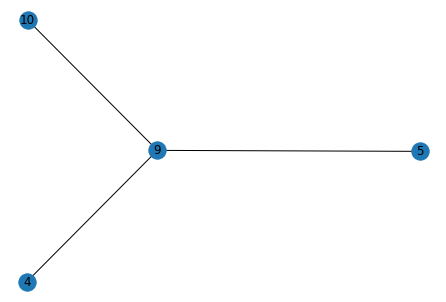

match_branches = [[4, 9], [5, 10]]
edges_to_delete (resolve crossover) = [[4, 5], [4, 10], [5, 9], [9, 10]]
edges_to_create (resolve crossover) = [[4, 9], [5, 10]]
curr_limb.deleted_edges 5 =[]
NOT USING the resolve crossover delete edges because not help resolve the cut
skip_nodes = []

Attempting the doubling back check (symmetrical so don't need to check from both sides)


  Edge: [11  9]: curr_angle = 23.87
  Edge: [ 9 10]: curr_angle = 130.86
  Edge: [10 13]: curr_angle = 0.78
  Edge: [13 16]: curr_angle = 20.88

Total time for doubling_back = 0.14618158340454102
There were 1 edges that passed doubling back threshold of 80
Winning edge [ 9 10] had a doubling back of 130.85689683743755
***inside resolve crossover!!!!****
coordinate_branches = [4, 5, 9, 10]
4 = red
5 = aqua
9 = purple
10 = green
Angle between 4 and 5 = 125.91 
Angle between 4 and 9 = 27.66 
Angle between 4 and 10 = 60.0 
Angle between 5 and 9 = 30.13 
Angle between 5 and 10 = 18.94 
Angle between 9 and 10 = 136.75 
Final Matches = [[4, 9], [5, 9], [5, 10]]
matched_branches_revised = [[5, 10], [4, 9]]
Original graph


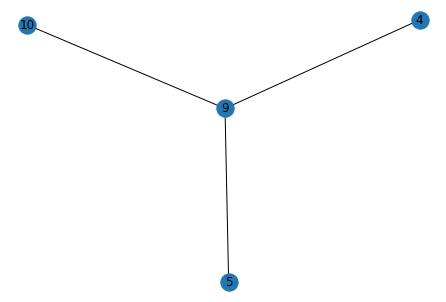

match_branches = [[5, 10], [4, 9]]
edges_to_delete (resolve crossover) = [[4, 5], [4, 10], [5, 9], [9, 10]]
edges_to_create (resolve crossover) = [[5, 10], [4, 9]]
edges_to_delete (cut_limb_network) = [array([4, 5]), array([ 4, 10]), array([5, 9]), array([ 9, 10])]
edges_to_create = [[5, 10], [4, 9]]
Number of connected components = 3
Comp 0 = {0, 1, 5, 7, 10, 12, 13, 14, 15, 16, 17, 18}
Comp 1 = {2, 3, 4, 6, 9, 11}
Comp 2 = {8}
curr_limb_copy.deleted_edges = [array([4, 5]), array([ 4, 10]), array([5, 9]), array([ 9, 10])]
curr_limb_copy.created_edges = [[5, 10], [4, 9]]
After get best cut: cut_edges = [array([4, 5]), array([ 4, 10]), array([5, 9]), array([ 9, 10])], added_edges = [[5, 10], [4, 9]]
total_soma_paths_to_cut = []


suggested_cut_points = [[ 825508.   606755.5 1055870. ]]




-----------counter = 0------------
 Cut iteration 1
Total number of graphs at the end of the split BEFORE DIRECTIONAL = 3
Total number of graphs at the end of the split AFTER DIRECTIONAL = 3
No valid path so moving onto the next connection
Total number of graphs at the end of the split = 3: [array([ 0,  1,  5,  7, 10, 12, 13, 14, 15, 16, 17, 18]), array([ 2,  3,  4,  6,  9, 11]), array([8])]


 ------ Total time for Splitting 864691135373702729 = 45.48052215576172 ------


----- Working on Neuron 864691135968888677-------
Decompressing Neuron in minimal output mode...please wait
multi_soma_limbs = []
multi_touch_limbs = []


 ------ Total time for Splitting 864691135968888677 = 26.041675806045532 ------


----- Working on Neuron 864691135472013106-------
Decompressing Neuron in minimal output mode...please wait
multi_soma_limbs = []
multi_touch_limbs = [1]


 -------- Working on limb 1------------
Starting combinations to process = [[10 21]]


---- working on disconnecting 10 and 21
--

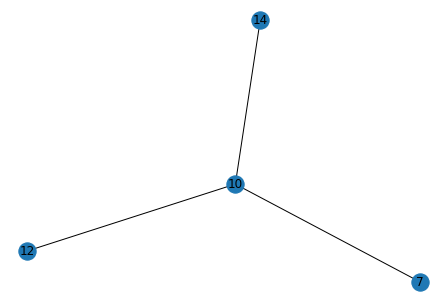

match_branches = [[10, 14]]
edges_to_delete (resolve crossover) = [[7, 10], [7, 12], [7, 14], [10, 12], [12, 14]]
edges_to_create (resolve crossover) = [[10, 14]]
curr_limb.deleted_edges 5 =[]
NOT USING the resolve crossover delete edges because not help resolve the cut
Picking [ 847799.23393765  832632.82993033 1054329.93543103] high degree coordinates to cut
curr_limb.deleted_edges 4=[]
***inside resolve crossover!!!!****
coordinate_branches = [9, 18, 24, 28, 30, 31]
9 = red
18 = aqua
24 = purple
28 = green
Angle between 9 and 18 = 75.27 
Angle between 9 and 24 = 64.16 
Angle between 9 and 28 = 117.99 
Angle between 9 and 30 = 53.72 
Angle between 9 and 31 = 79.09 
Angle between 18 and 24 = 43.3 
Angle between 18 and 28 = 15.57 
Angle between 18 and 30 = 118.44 
Angle between 18 and 31 = 47.03 
Angle between 24 and 28 = 125.78 
Angle between 24 and 30 = 98.18 
Angle between 24 and 31 = 152.64 
Angle between 28 and 30 = 61.78 
Angle between 28 and 31 = 130.88 
Angle between 30 and 31 

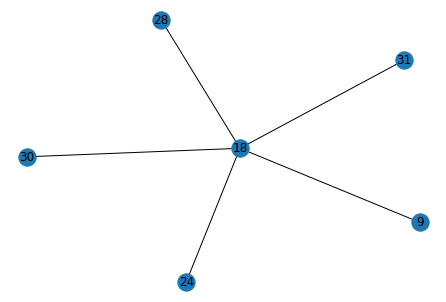

match_branches = [[18, 28]]
edges_to_delete (resolve crossover) = [[9, 18], [9, 24], [9, 28], [9, 30], [9, 31], [18, 24], [18, 30], [18, 31], [24, 28], [24, 30], [24, 31], [28, 30], [28, 31], [30, 31]]
edges_to_create (resolve crossover) = [[18, 28]]
curr_limb.deleted_edges 5 =[]
NOT USING the resolve crossover delete edges because not help resolve the cut
Picking [ 900716.14842936  830327.34502641 1055771.1968163 ] high degree coordinates to cut
curr_limb.deleted_edges 4=[]
***inside resolve crossover!!!!****
coordinate_branches = [44, 45, 53, 54]
44 = red
45 = aqua
53 = purple
54 = green
Angle between 44 and 45 = 140.82 
Angle between 44 and 53 = 16.77 
Angle between 44 and 54 = 27.81 
Angle between 45 and 53 = 39.02 
Angle between 45 and 54 = 47.55 
Angle between 53 and 54 = 167.96 
Final Matches = [[44, 53], [44, 54]]
matched_branches_revised = [[44, 53]]
Original graph


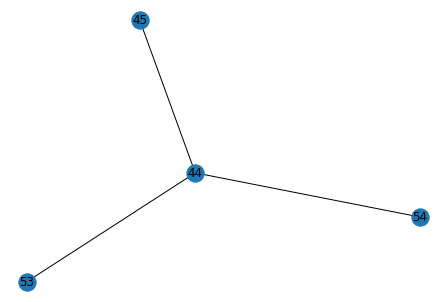

match_branches = [[44, 53]]
edges_to_delete (resolve crossover) = [[44, 45], [44, 54], [45, 53], [45, 54], [53, 54]]
edges_to_create (resolve crossover) = [[44, 53]]
curr_limb.deleted_edges 5 =[]
NOT USING the resolve crossover delete edges because not help resolve the cut
Picking [ 904499.88688458  830715.93506759 1054364.4343174 ] high degree coordinates to cut
curr_limb.deleted_edges 4=[]
***inside resolve crossover!!!!****
coordinate_branches = [38, 51, 53, 56]
38 = red
51 = aqua
53 = purple
56 = green
Angle between 38 and 51 = 86.9 
Angle between 38 and 53 = 149.39 
Angle between 38 and 56 = 30.71 
Angle between 51 and 53 = 83.75 
Angle between 51 and 56 = 76.2 
Angle between 53 and 56 = 20.58 
Final Matches = [[38, 56], [53, 56]]
matched_branches_revised = [[53, 56]]
Original graph


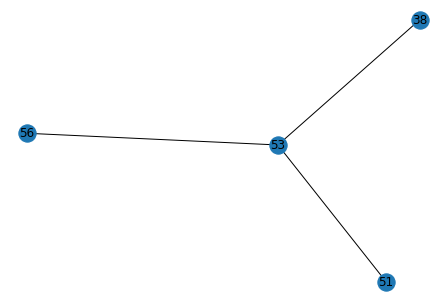

match_branches = [[53, 56]]
edges_to_delete (resolve crossover) = [[38, 51], [38, 53], [38, 56], [51, 53], [51, 56]]
edges_to_create (resolve crossover) = [[53, 56]]
curr_limb.deleted_edges 5 =[]
NOT USING the resolve crossover delete edges because not help resolve the cut
skip_nodes = []

Attempting the doubling back check (symmetrical so don't need to check from both sides)


  Edge: [10 12]: curr_angle = 38.52
  Edge: [12 20]: curr_angle = 35.92
  Edge: [20 19]: curr_angle = 101.63
  Edge: [19 23]: curr_angle = 100.13
  Edge: [23 18]: curr_angle = 23.59
  Edge: [18 31]: curr_angle = 47.16
  Edge: [31 44]: curr_angle = 19.43
  Edge: [44 53]: curr_angle = 22.15
  Edge: [53 38]: curr_angle = 167.0
  Edge: [38 34]: curr_angle = 12.45
  Edge: [34 21]: curr_angle = 12.77

Total time for doubling_back = 1.055863618850708
There were 3 edges that passed doubling back threshold of 80
Winning edge [53 38] had a doubling back of 167.0040129698349
***inside resolve crossover!!!!****
coordinate_branches = [38, 51, 53, 56]
38 = red
51 = aqua
53 = purple
56 = green
Angle between 38 and 51 = 95.24 
Angle between 38 and 53 = 126.58 
Angle between 38 and 56 = 38.1 
Angle between 51 and 53 = 91.92 
Angle between 51 and 56 = 75.71 
Angle between 53 and 56 = 19.93 
Final Matches = [[53, 56]]
matched_branches_revised = [[53, 56]]
Original graph


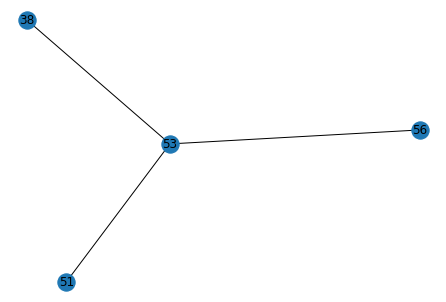

match_branches = [[53, 56]]
edges_to_delete (resolve crossover) = [[38, 51], [38, 53], [38, 56], [51, 53], [51, 56]]
edges_to_create (resolve crossover) = [[53, 56]]
edges_to_delete (cut_limb_network) = [array([38, 51]), array([38, 53]), array([38, 56]), array([51, 53]), array([51, 56])]
edges_to_create = [[53, 56]]
Number of connected components = 6
Comp 0 = {0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 23, 24, 25, 27, 28, 29, 30, 31, 32, 35, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 53, 54, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67}
Comp 1 = {33, 34, 3, 36, 37, 38, 21}
Comp 2 = {51}
Comp 3 = {26}
Comp 4 = {52}
Comp 5 = {55}
curr_limb_copy.deleted_edges = [array([38, 51]), array([38, 53]), array([38, 56]), array([51, 53]), array([51, 56])]
curr_limb_copy.created_edges = [[53, 56]]
After get best cut: cut_edges = [array([38, 51]), array([38, 53]), array([38, 56]), array([51, 53]), array([51, 56])], added_edges = [[53, 56]]
total_soma_paths_to_cu

-----------counter = 0------------
 Cut iteration 1
Total number of graphs at the end of the split BEFORE DIRECTIONAL = 6
Total number of graphs at the end of the split AFTER DIRECTIONAL = 6
No valid path so moving onto the next connection
Total number of graphs at the end of the split = 6: [array([ 0,  1,  2,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 22, 23, 24, 25, 27, 28, 29, 30, 31, 32, 35, 39, 40, 41,
       42, 43, 44, 45, 46, 47, 48, 49, 50, 53, 54, 56, 57, 58, 59, 60, 61,
       62, 63, 64, 65, 66, 67]), array([33, 34,  3, 36, 37, 38, 21]), array([51]), array([26]), array([52]), array([55])]


 ------ Total time for Splitting 864691135472013106 = 66.93638634681702 ------


----- Working on Neuron 864691135355527666-------
Decompressing Neuron in minimal output mode...please wait
multi_soma_limbs = []
multi_touch_limbs = []


 ------ Total time for Splitting 864691135355527666 = 13.846132040023804 ------


----- Working on Neuron 8646911349534271

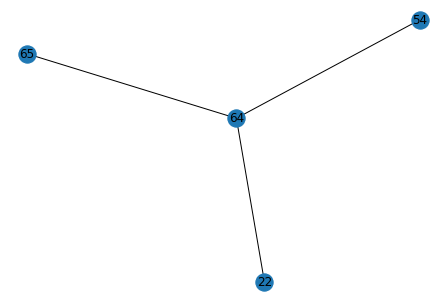

match_branches = [[22, 64]]
edges_to_delete (resolve crossover) = [[22, 54], [22, 65], [54, 64], [54, 65], [64, 65]]
edges_to_create (resolve crossover) = [[22, 64]]
curr_limb.deleted_edges 5 =[]
NOT USING the resolve crossover delete edges because not help resolve the cut
Picking [ 811720.6858155  1046966.70994977  933091.42345004] high degree coordinates to cut
curr_limb.deleted_edges 4=[]
***inside resolve crossover!!!!****
coordinate_branches = [65, 75, 76, 78]
65 = red
75 = aqua
76 = purple
78 = green
Angle between 65 and 75 = 36.55 
Angle between 65 and 76 = 30.74 
Angle between 65 and 78 = 91.37 
Angle between 75 and 76 = 163.02 
Angle between 75 and 78 = 80.79 
Angle between 76 and 78 = 68.42 
Final Matches = [[65, 76]]
matched_branches_revised = [[65, 76]]
Original graph


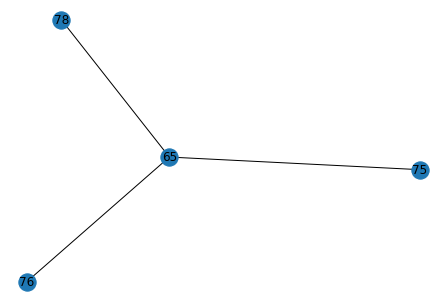

match_branches = [[65, 76]]
edges_to_delete (resolve crossover) = [[65, 75], [65, 78], [75, 76], [75, 78], [76, 78]]
edges_to_create (resolve crossover) = [[65, 76]]
curr_limb.deleted_edges 5 =[]
NOT USING the resolve crossover delete edges because not help resolve the cut
Picking [ 818111.19729674 1046791.3966887   930795.2879548 ] high degree coordinates to cut
curr_limb.deleted_edges 4=[]
***inside resolve crossover!!!!****
coordinate_branches = [59, 64, 72, 93]
59 = red
64 = aqua
72 = purple
93 = green
Angle between 59 and 64 = 110.88 
Angle between 59 and 72 = 163.55 
Angle between 59 and 93 = 111.14 
Angle between 64 and 72 = 110.08 
Angle between 64 and 93 = 50.17 
Angle between 72 and 93 = 117.95 
Final Matches = []
matched_branches_revised = []
Original graph


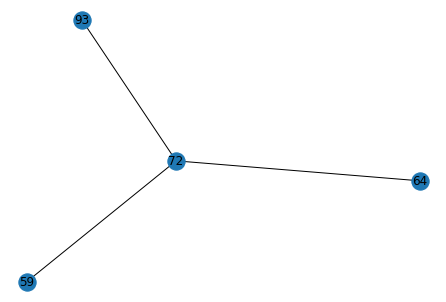

match_branches = []
edges_to_delete (resolve crossover) = [[59, 64], [59, 72], [59, 93], [64, 72], [64, 93], [72, 93]]
edges_to_create (resolve crossover) = []
curr_limb.deleted_edges 5 =[]
NOT USING the resolve crossover delete edges because not help resolve the cut
Skipping endnode 109 because skeletal distance was 987.0278814135548 and threshold was 2500
skip_nodes = [109]

Attempting the doubling back check (symmetrical so don't need to check from both sides)


  Edge: [103  72]: curr_angle = 13.73
  Edge: [72 64]: curr_angle = 100.08
  Edge: [64 65]: curr_angle = 151.18
  Edge: [65 75]: curr_angle = 169.28

Total time for doubling_back = 0.1974492073059082
There were 3 edges that passed doubling back threshold of 80
Winning edge [65 75] had a doubling back of 169.2815670705806
***inside resolve crossover!!!!****
coordinate_branches = [65, 75, 76, 78]
65 = red
75 = aqua
76 = purple
78 = green
Angle between 65 and 75 = 23.5 
Angle between 65 and 76 = 27.33 
Angle between 65 and 78 = 75.12 
Angle between 75 and 76 = 159.29 
Angle between 75 and 78 = 89.92 
Angle between 76 and 78 = 77.59 
Final Matches = [[65, 75], [65, 76]]
matched_branches_revised = [[65, 75]]
Original graph


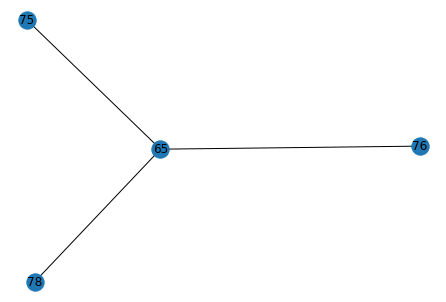

match_branches = [[65, 75]]
edges_to_delete (resolve crossover) = [[65, 76], [65, 78], [75, 76], [75, 78], [76, 78]]
edges_to_create (resolve crossover) = [[65, 75]]
Rejecting creating edge [65, 75] becuase did not involve only 1 node in the deleted edge
edges_to_delete (cut_limb_network) = [array([65, 75]), array([65, 76]), array([65, 78]), array([75, 76]), array([75, 78]), array([76, 78])]
edges_to_create = []
Number of connected components = 4
Comp 0 = {8, 138, 139, 11, 16, 17, 18, 21, 22, 23, 26, 28, 30, 47, 54, 59, 60, 64, 65, 67, 72, 74, 79, 93, 103}
Comp 1 = {0, 1, 2, 3, 4, 5, 6, 9, 10, 12, 13, 14, 15, 20, 25, 27, 32, 33, 34, 35, 36, 37, 38, 40, 41, 42, 43, 44, 45, 46, 48, 49, 50, 51, 52, 53, 55, 56, 58, 61, 62, 63, 66, 68, 69, 70, 73, 75, 80, 84, 85, 87, 88, 89, 90, 91, 94, 95, 96, 97, 98, 99, 100, 101, 102, 105, 106, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 121, 122, 123, 124, 125, 126, 127, 130, 131}
Comp 2 = {128, 129, 132, 133, 134, 7, 135, 137, 136, 39, 57, 76, 81

-----------counter = 0------------
 Cut iteration 1
Total number of graphs at the end of the split BEFORE DIRECTIONAL = 4
Total number of graphs at the end of the split AFTER DIRECTIONAL = 4
No valid path so moving onto the next connection


---- working on disconnecting 103 and 119
---- This disconnects S0_0 from S0_2  
 Cut iteration 0
Total number of graphs at the end of the split BEFORE DIRECTIONAL = 4
Total number of graphs at the end of the split AFTER DIRECTIONAL = 4
No valid path so moving onto the next connection


---- working on disconnecting 109 and 119
---- This disconnects S0_1 from S0_2  
 Cut iteration 0
Total number of graphs at the end of the split BEFORE DIRECTIONAL = 4
Total number of graphs at the end of the split AFTER DIRECTIONAL = 4
No valid path so moving onto the next connection
Total number of graphs at the end of the split = 4: [array([  8, 138, 139,  11,  16,  17,  18,  21,  22,  23,  26,  28,  30,
        47,  54,  59,  60,  64,  65,  67,  72,  74,  79,  9

  Edge: [31 13]: curr_angle = 60.74
  Edge: [13 83]: curr_angle = 116.01
  Edge: [83 15]: curr_angle = 100.42
  Edge: [15 35]: curr_angle = 70.11
  Edge: [35 56]: curr_angle = 57.54

Total time for doubling_back = 0.3817436695098877
There were 2 edges that passed doubling back threshold of 80
Winning edge [13 83] had a doubling back of 116.009111538645
***inside resolve crossover!!!!****
coordinate_branches = [5, 13, 83]
5 = red
13 = aqua
83 = purple
Angle between 5 and 13 = 17.3 
Angle between 5 and 83 = 80.42 
Angle between 13 and 83 = 92.14 
Final Matches = [[5, 13]]
matched_branches_revised = [[5, 13]]
Original graph


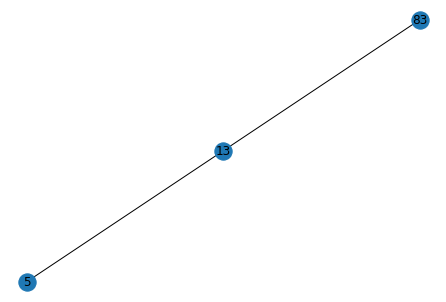

match_branches = [[5, 13]]
edges_to_delete (resolve crossover) = [[5, 83], [13, 83]]
edges_to_create (resolve crossover) = [[5, 13]]
edges_to_delete (cut_limb_network) = [array([ 5, 83]), array([13, 83])]
edges_to_create = [[5, 13]]
Number of connected components = 2
Comp 0 = {0, 1, 2, 4, 6, 7, 9, 10, 12, 14, 15, 16, 17, 18, 19, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 32, 33, 34, 35, 36, 37, 38, 39, 40, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83}
Comp 1 = {3, 5, 8, 41, 11, 13, 20, 31}
curr_limb_copy.deleted_edges = [array([ 5, 83]), array([13, 83])]
curr_limb_copy.created_edges = [[5, 13]]
After get best cut: cut_edges = [array([ 5, 83]), array([13, 83])], added_edges = [[5, 13]]
total_soma_paths_to_cut = []


suggested_cut_points = [[ 811752.  529796. 1068710.]]




-----------counter = 0------------
 Cut iteration 1
Total number of graphs at the end of the split BEFORE DIRECTIONAL = 2
Total number of graphs at the end of the split AFTER DIRECTIONAL = 2
No valid path so moving onto the next connection
Total number of graphs at the end of the split = 2: [array([ 0,  1,  2,  4,  6,  7,  9, 10, 12, 14, 15, 16, 17, 18, 19, 21, 22,
       23, 24, 25, 26, 27, 28, 29, 30, 32, 33, 34, 35, 36, 37, 38, 39, 40,
       42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58,
       59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75,
       76, 77, 78, 79, 80, 81, 82, 83]), array([ 3,  5,  8, 41, 11, 13, 20, 31])]


 ------ Total time for Splitting 864691135474597696 = 80.0328733921051 ------


----- Working on Neuron 864691135513808626-------
Decompressing Neuron in minimal output mode...please wait
multi_soma_limbs = []
multi_touch_limbs = []


 ------ Total time for Splitting 864691135513808626 = 34.62691044807434 ------


----- W

  Edge: [0 1]: curr_angle = 135.59

Total time for doubling_back = 0.04400920867919922
There were 1 edges that passed doubling back threshold of 80
Winning edge [0 1] had a doubling back of 135.59216229780895
***inside resolve crossover!!!!****
coordinate_branches = [0, 1, 2]
0 = red
1 = aqua
2 = purple
Angle between 0 and 1 = 107.91 
Angle between 0 and 2 = 119.01 
Angle between 1 and 2 = 122.65 
Final Matches = []
matched_branches_revised = []
Original graph


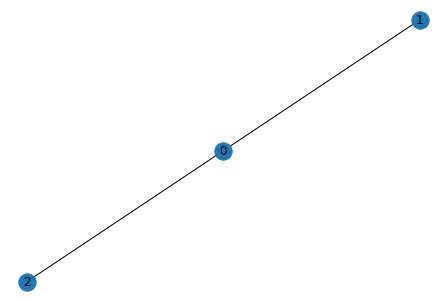

match_branches = []
edges_to_delete (resolve crossover) = [[0, 1], [0, 2], [1, 2]]
edges_to_create (resolve crossover) = []
edges_to_delete (cut_limb_network) = [array([0, 1]), array([0, 2]), array([1, 2])]
edges_to_create = []
Number of connected components = 3
Comp 0 = {0}
Comp 1 = {1}
Comp 2 = {2}
curr_limb_copy.deleted_edges = [array([0, 1]), array([0, 2]), array([1, 2])]
curr_limb_copy.created_edges = []
After get best cut: cut_edges = [array([0, 1]), array([0, 2]), array([1, 2])], added_edges = []
total_soma_paths_to_cut = []


suggested_cut_points = [[ 873396.39760111 1084471.80481115  614838.90014414]]




-----------counter = 0------------
 Cut iteration 1
Total number of graphs at the end of the split BEFORE DIRECTIONAL = 3
Total number of graphs at the end of the split AFTER DIRECTIONAL = 3
No valid path so moving onto the next connection


---- working on disconnecting 0 and 2
---- This disconnects S0_0 from S0_3  
 Cut iteration 0
Total number of graphs at the end of the split BEFORE DIRECTIONAL = 3
Total number of graphs at the end of the split AFTER DIRECTIONAL = 3
No valid path so moving onto the next connection


---- working on disconnecting 1 and 2
---- This disconnects S0_2 from S0_3  
 Cut iteration 0
Total number of graphs at the end of the split BEFORE DIRECTIONAL = 3
Total number of graphs at the end of the split AFTER DIRECTIONAL = 3
No valid path so moving onto the next connection
Total number of graphs at the end of the split = 3: [array([0]), array([1]), array([2])]


 ------ Total time for Splitting 864691136400919084 = 2.2746975421905518 ------


----- Working on Ne

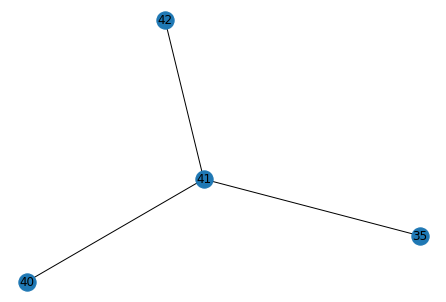

match_branches = [[35, 40]]
edges_to_delete (resolve crossover) = [[35, 41], [35, 42], [40, 41], [40, 42], [41, 42]]
edges_to_create (resolve crossover) = [[35, 40]]
curr_limb.deleted_edges 5 =[]
NOT USING the resolve crossover delete edges because not help resolve the cut
skip_nodes = []

Attempting the doubling back check (symmetrical so don't need to check from both sides)


  Edge: [30 31]: curr_angle = 91.95
  Edge: [31 39]: curr_angle = 31.69
  Edge: [39 41]: curr_angle = 127.16
  Edge: [41 35]: curr_angle = 67.59

Total time for doubling_back = 0.3424651622772217
There were 2 edges that passed doubling back threshold of 80
Winning edge [39 41] had a doubling back of 127.15503567271672
***inside resolve crossover!!!!****
coordinate_branches = [39, 41, 47]
39 = red
41 = aqua
47 = purple
Angle between 39 and 41 = 121.65 
Angle between 39 and 47 = 35.2 
Angle between 41 and 47 = 23.63 
Final Matches = [[41, 47]]
matched_branches_revised = [[41, 47]]
Original graph


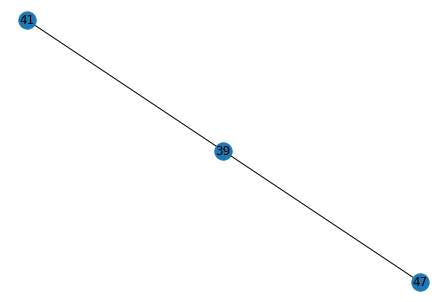

match_branches = [[41, 47]]
edges_to_delete (resolve crossover) = [[39, 41], [39, 47]]
edges_to_create (resolve crossover) = [[41, 47]]
edges_to_delete (cut_limb_network) = [array([39, 41]), array([39, 47])]
edges_to_create = [[41, 47]]
Number of connected components = 2
Comp 0 = {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 36, 37, 38, 39, 45, 46, 48, 49, 50, 51}
Comp 1 = {35, 40, 41, 42, 43, 44, 47}
curr_limb_copy.deleted_edges = [array([39, 41]), array([39, 47])]
curr_limb_copy.created_edges = [[41, 47]]
After get best cut: cut_edges = [array([39, 41]), array([39, 47])], added_edges = [[41, 47]]
total_soma_paths_to_cut = []


suggested_cut_points = [[982848. 435014. 999134.]]




-----------counter = 0------------
 Cut iteration 1
Total number of graphs at the end of the split BEFORE DIRECTIONAL = 2
Total number of graphs at the end of the split AFTER DIRECTIONAL = 2
No valid path so moving onto the next connection
Total number of graphs at the end of the split = 2: [array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 36, 37, 38, 39, 45, 46, 48, 49, 50, 51]), array([35, 40, 41, 42, 43, 44, 47])]


 ------ Total time for Splitting 864691135589899787 = 54.90035367012024 ------


----- Working on Neuron 864691135012910998-------
Decompressing Neuron in minimal output mode...please wait
multi_soma_limbs = []
multi_touch_limbs = []


 ------ Total time for Splitting 864691135012910998 = 21.242177963256836 ------


----- Working on Neuron 864691135672812228-------
Decompressing Neuron in minimal output mode...please wait
multi_soma_limbs = []
multi_touch_limbs

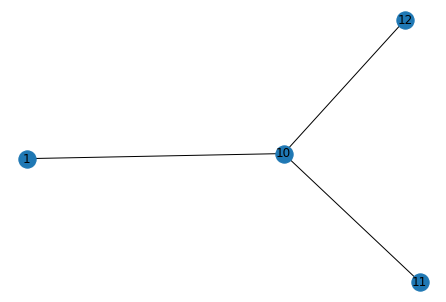

match_branches = [[1, 12]]
edges_to_delete (resolve crossover) = [[1, 10], [1, 11], [10, 11], [10, 12], [11, 12]]
edges_to_create (resolve crossover) = [[1, 12]]
curr_limb.deleted_edges 5 =[]
NOT USING the resolve crossover delete edges because not help resolve the cut
skip_nodes = []

Attempting the doubling back check (symmetrical so don't need to check from both sides)


  Edge: [0 4]: curr_angle = 67.92
  Edge: [ 4 21]: curr_angle = 62.21
  Edge: [21 35]: curr_angle = 67.63
  Edge: [35 34]: curr_angle = 114.35
  Edge: [34 10]: curr_angle = 28.47
  Edge: [10  1]: curr_angle = 86.87

Total time for doubling_back = 0.24441790580749512
There were 2 edges that passed doubling back threshold of 80
Winning edge [35 34] had a doubling back of 114.35340661580025
***inside resolve crossover!!!!****
coordinate_branches = [34, 35, 37]
34 = red
35 = aqua
37 = purple
Angle between 34 and 35 = 61.47 
Angle between 34 and 37 = 17.38 
Angle between 35 and 37 = 109.98 
Final Matches = [[34, 37]]
matched_branches_revised = [[34, 37]]
Original graph


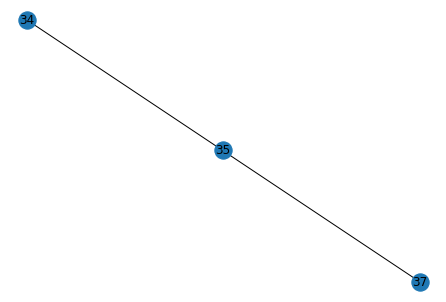

match_branches = [[34, 37]]
edges_to_delete (resolve crossover) = [[34, 35], [35, 37]]
edges_to_create (resolve crossover) = [[34, 37]]
edges_to_delete (cut_limb_network) = [array([34, 35]), array([35, 37])]
edges_to_create = [[34, 37]]
Number of connected components = 3
Comp 0 = {0, 3, 4, 35, 6, 7, 36, 41, 42, 43, 38, 21, 22}
Comp 1 = {1, 2, 5, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 37, 39, 40, 44, 45, 46, 47, 48.0, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67}
Comp 2 = {9}
curr_limb_copy.deleted_edges = [array([34, 35]), array([35, 37])]
curr_limb_copy.created_edges = [[34, 37]]
After get best cut: cut_edges = [array([34, 35]), array([35, 37])], added_edges = [[34, 37]]
total_soma_paths_to_cut = []


suggested_cut_points = [[1095280.  390752.  616813.]]




-----------counter = 0------------
 Cut iteration 1
Total number of graphs at the end of the split BEFORE DIRECTIONAL = 3
Total number of graphs at the end of the split AFTER DIRECTIONAL = 3
No valid path so moving onto the next connection
Total number of graphs at the end of the split = 3: [array([ 0,  3,  4, 35,  6,  7, 36, 41, 42, 43, 38, 21, 22]), array([ 1.,  2.,  5.,  8., 10., 11., 12., 13., 14., 15., 16., 17., 18.,
       19., 20., 23., 24., 25., 26., 27., 28., 29., 30., 31., 32., 33.,
       34., 37., 39., 40., 44., 45., 46., 47., 48., 49., 50., 51., 52.,
       53., 54., 55., 56., 57., 58., 59., 60., 61., 62., 63., 64., 65.,
       66., 67.]), array([9])]


 ------ Total time for Splitting 864691135603147843 = 59.52576041221619 ------


----- Working on Neuron 864691135864719580-------
Decompressing Neuron in minimal output mode...please wait
multi_soma_limbs = []
multi_touch_limbs = []


 ------ Total time for Splitting 864691135864719580 = 32.16470265388489 ------


----- Wo

  Edge: [13 14]: curr_angle = 22.45
  Edge: [14 16]: curr_angle = 74.69
  Edge: [16 30]: curr_angle = 45.36
  Edge: [30 34]: curr_angle = 75.19
  Edge: [34 25]: curr_angle = 160.28
  Edge: [25 19]: curr_angle = 80.83
  Edge: [19 17]: curr_angle = 24.8

Total time for doubling_back = 0.44933009147644043
There were 2 edges that passed doubling back threshold of 80
Winning edge [34 25] had a doubling back of 160.27608535163156
***inside resolve crossover!!!!****
coordinate_branches = [25, 34, 36]
25 = red
34 = aqua
36 = purple
Angle between 25 and 34 = 82.4 
Angle between 25 and 36 = 12.85 
Angle between 34 and 36 = 87.87 
Final Matches = [[25, 36]]
matched_branches_revised = [[25, 36]]
Original graph


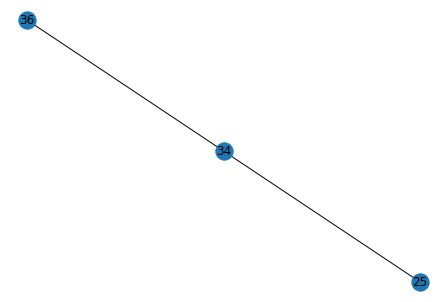

match_branches = [[25, 36]]
edges_to_delete (resolve crossover) = [[25, 34], [34, 36]]
edges_to_create (resolve crossover) = [[25, 36]]
edges_to_delete (cut_limb_network) = [array([25, 34]), array([34, 36])]
edges_to_create = [[25, 36]]
Number of connected components = 2
Comp 0 = {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 22, 23, 26, 27, 30, 31, 34, 35}
Comp 1 = {17, 18, 19, 20, 21, 24, 25, 28, 29, 32, 33, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50}
curr_limb_copy.deleted_edges = [array([25, 34]), array([34, 36])]
curr_limb_copy.created_edges = [[25, 36]]
After get best cut: cut_edges = [array([25, 34]), array([34, 36])], added_edges = [[25, 36]]
total_soma_paths_to_cut = []


suggested_cut_points = [[1102080.  513555.  611486.]]




-----------counter = 0------------
 Cut iteration 1
Total number of graphs at the end of the split BEFORE DIRECTIONAL = 2
Total number of graphs at the end of the split AFTER DIRECTIONAL = 2
No valid path so moving onto the next connection
Total number of graphs at the end of the split = 2: [array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       22, 23, 26, 27, 30, 31, 34, 35]), array([17, 18, 19, 20, 21, 24, 25, 28, 29, 32, 33, 36, 37, 38, 39, 40, 41,
       42, 43, 44, 45, 46, 47, 48, 49, 50])]


 ------ Total time for Splitting 864691135876003667 = 43.45621609687805 ------


----- Working on Neuron 864691135274119397-------
Decompressing Neuron in minimal output mode...please wait
multi_soma_limbs = []
multi_touch_limbs = [2]


 -------- Working on limb 2------------
Starting combinations to process = [[40 45]]


---- working on disconnecting 40 and 45
---- This disconnects S0_0 from S0_1  
 Cut iteration 0
Total number of graphs at the end of the split BE

  Edge: [36 27]: curr_angle = 30.82
  Edge: [27 25]: curr_angle = 50.53
  Edge: [25 26]: curr_angle = 151.78
  Edge: [26 56]: curr_angle = 115.28
  Edge: [56 48]: curr_angle = 23.21

Total time for doubling_back = 0.2666492462158203
There were 2 edges that passed doubling back threshold of 80
Winning edge [25 26] had a doubling back of 151.77857706137283
***inside resolve crossover!!!!****
coordinate_branches = [22, 25, 26]
22 = red
25 = aqua
26 = purple
Angle between 22 and 25 = 20.19 
Angle between 22 and 26 = 47.22 
Angle between 25 and 26 = 125.33 
Final Matches = [[22, 25]]
matched_branches_revised = [[22, 25]]
Original graph


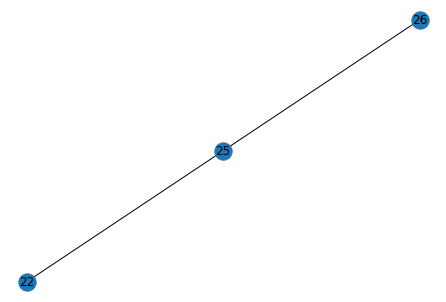

match_branches = [[22, 25]]
edges_to_delete (resolve crossover) = [[22, 26], [25, 26]]
edges_to_create (resolve crossover) = [[22, 25]]
edges_to_delete (cut_limb_network) = [array([22, 26]), array([25, 26])]
edges_to_create = [[22, 25]]
Number of connected components = 2
Comp 0 = {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43}
Comp 1 = {12, 26, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72}
curr_limb_copy.deleted_edges = [array([22, 26]), array([25, 26])]
curr_limb_copy.created_edges = [[22, 25]]
After get best cut: cut_edges = [array([22, 26]), array([25, 26])], added_edges = [[22, 25]]
total_soma_paths_to_cut = []


suggested_cut_points = [[1044698.02131383  552855.31683172  619724.84953974]]




-----------counter = 0------------
 Cut iteration 1
Total number of graphs at the end of the split BEFORE DIRECTIONAL = 2
Total number of graphs at the end of the split AFTER DIRECTIONAL = 2
No valid path so moving onto the next connection
Total number of graphs at the end of the split = 2: [array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 43]), array([12, 26, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58,
       59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72])]


 ------ Total time for Splitting 864691135274119397 = 43.55631899833679 ------


----- Working on Neuron 864691135181768706-------
Decompressing Neuron in minimal output mode...please wait
multi_soma_limbs = []
multi_touch_limbs = []


 ------ Total time for Splitting 864691135181768706 = 45.01134991645813 ------


----- Working on Neuron 864691135975461443-------
Decompr

  Edge: [15 12]: curr_angle = 32.99
  Edge: [12 13]: curr_angle = 158.29
  Edge: [13 16]: curr_angle = 32.33

Total time for doubling_back = 0.22109198570251465
There were 1 edges that passed doubling back threshold of 80
Winning edge [12 13] had a doubling back of 158.28748065692497
***inside resolve crossover!!!!****
coordinate_branches = [11, 12, 13]
11 = red
12 = aqua
13 = purple
Angle between 11 and 12 = 28.74 
Angle between 11 and 13 = 34.04 
Angle between 12 and 13 = 171.58 
Final Matches = [[11, 12], [11, 13]]
matched_branches_revised = [[11, 12]]
Original graph


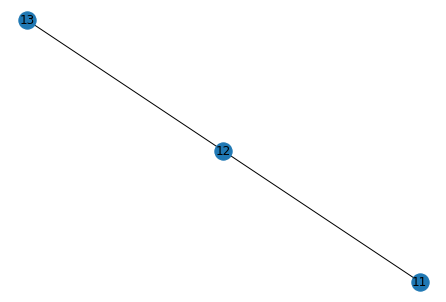

match_branches = [[11, 12]]
edges_to_delete (resolve crossover) = [[11, 13], [12, 13]]
edges_to_create (resolve crossover) = [[11, 12]]
edges_to_delete (cut_limb_network) = [array([11, 13]), array([12, 13])]
edges_to_create = [[11, 12]]
Number of connected components = 2
Comp 0 = {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 14, 15}
Comp 1 = {16, 10, 13}
curr_limb_copy.deleted_edges = [array([11, 13]), array([12, 13])]
curr_limb_copy.created_edges = [[11, 12]]
After get best cut: cut_edges = [array([11, 13]), array([12, 13])], added_edges = [[11, 12]]
total_soma_paths_to_cut = []


suggested_cut_points = [[1108130.  777820.  665904.]]




-----------counter = 0------------
 Cut iteration 1
Total number of graphs at the end of the split BEFORE DIRECTIONAL = 2
Total number of graphs at the end of the split AFTER DIRECTIONAL = 2
No valid path so moving onto the next connection
Total number of graphs at the end of the split = 2: [array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 11, 12, 14, 15]), array([16, 10, 13])]


 ------ Total time for Splitting 864691135560487649 = 31.654637813568115 ------


----- Working on Neuron 864691135510810610-------
Decompressing Neuron in minimal output mode...please wait
multi_soma_limbs = []
multi_touch_limbs = [0]


 -------- Working on limb 0------------
Starting combinations to process = [[110 118]
 [110 133]
 [110 142]
 [118 133]
 [118 142]
 [133 142]]


---- working on disconnecting 110 and 118
---- This disconnects S0_2 from S0_1  
 Cut iteration 0
Total number of graphs at the end of the split BEFORE DIRECTIONAL = 1
Total number of graphs at the end of the split AFTER DIRECTIONAL = 1


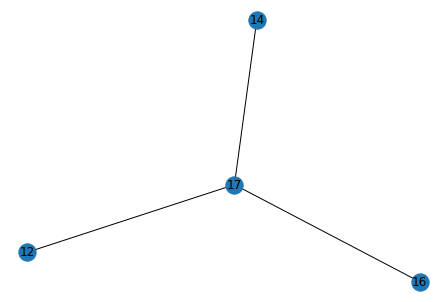

match_branches = [[14, 16]]
edges_to_delete (resolve crossover) = [[12, 14], [12, 16], [12, 17], [14, 17], [16, 17]]
edges_to_create (resolve crossover) = [[14, 16]]
curr_limb.deleted_edges 5 =[]
NOT USING the resolve crossover delete edges because not help resolve the cut
Skipping endnode 118 because skeletal distance was 538.3651653496389 and threshold was 2500
skip_nodes = [118]

Attempting the doubling back check (symmetrical so don't need to check from both sides)


  Edge: [110 116]: curr_angle = 62.45
  Edge: [116 122]: curr_angle = 37.78
  Edge: [122 140]: curr_angle = 42.44
  Edge: [140 109]: curr_angle = 103.49
  Edge: [109  96]: curr_angle = 20.84
  Edge: [96 58]: curr_angle = 3.47
  Edge: [58 55]: curr_angle = 12.28
  Edge: [55 40]: curr_angle = 20.52
  Edge: [40 17]: curr_angle = 64.2
  Edge: [17 16]: curr_angle = 149.94
  Edge: [16 25]: curr_angle = 44.09
  Edge: [25 50]: curr_angle = 10.7

Total time for doubling_back = 0.8524885177612305
There were 2 edges that passed doubling back threshold of 80
Winning edge [17 16] had a doubling back of 149.94242342008002
***inside resolve crossover!!!!****
coordinate_branches = [12, 14, 16, 17]
12 = red
14 = aqua
16 = purple
17 = green
Angle between 12 and 14 = 167.41 
Angle between 12 and 16 = 16.76 
Angle between 12 and 17 = 40.95 
Angle between 14 and 16 = 13.95 
Angle between 14 and 17 = 30.04 
Angle between 16 and 17 = 138.85 
Final Matches = [[12, 16], [14, 16], [14, 17]]
matched_branches_rev

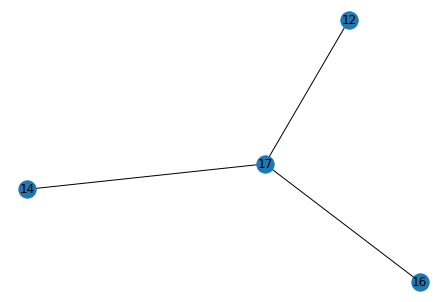

match_branches = [[14, 16]]
edges_to_delete (resolve crossover) = [[12, 14], [12, 16], [12, 17], [14, 17], [16, 17]]
edges_to_create (resolve crossover) = [[14, 16]]
edges_to_delete (cut_limb_network) = [array([12, 14]), array([12, 16]), array([12, 17]), array([14, 17]), array([16, 17])]
edges_to_create = [[14, 16]]
Number of connected components = 3
Comp 0 = {0, 1, 5, 6, 7, 8, 9, 10, 11, 13, 15, 17, 18, 19, 20, 22, 23, 24, 26, 27, 28, 29, 30, 31, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 98, 99, 100, 101, 104, 105, 107, 108, 109, 110, 112, 113, 114, 115, 116, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163

-----------counter = 0------------
 Cut iteration 1
Total number of graphs at the end of the split BEFORE DIRECTIONAL = 3
Total number of graphs at the end of the split AFTER DIRECTIONAL = 3
No valid path so moving onto the next connection


---- working on disconnecting 110 and 133
---- This disconnects S0_2 from S0_3  
 Cut iteration 0
Total number of graphs at the end of the split BEFORE DIRECTIONAL = 3
Total number of graphs at the end of the split AFTER DIRECTIONAL = 3
Shortest path = [110, 116, 123, 131, 135, 144, 143, 132, 134, 137, 133]

 --------- START OF GET BEST EDGE --------- 
curr_limb.deleted_edges=[array([12, 14]), array([12, 16]), array([12, 17]), array([14, 17]), array([16, 17])]
consider_path_neighbors_for_removal is set so segments_to_consider = [ 83 104 116 120 122 123 126 131 132 134 135 136 137 138 143 144 145 146
 153]
Short segments to combine = [143]


-------- Removing Segments -------------
curr_short_seg_revised = 143
np.sum(touch_len>0) = 2
Using average s

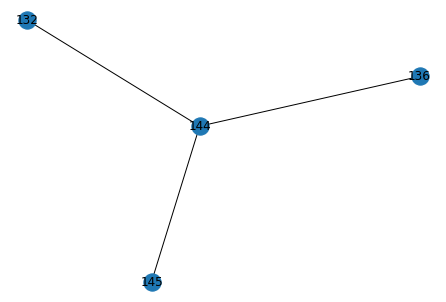

match_branches = [[136, 144]]
edges_to_delete (resolve crossover) = [[132, 136], [132, 144], [132, 145], [136, 145], [144, 145]]
edges_to_create (resolve crossover) = [[136, 144]]
curr_limb.deleted_edges 5 =[array([12, 14]), array([12, 16]), array([12, 17]), array([14, 17]), array([16, 17])]
NOT USING the resolve crossover delete edges because not help resolve the cut
Skipping endnode 133 because skeletal distance was 975.1731696067975 and threshold was 2500
skip_nodes = [133]

Attempting the doubling back check (symmetrical so don't need to check from both sides)


  Edge: [110 116]: curr_angle = 62.45
  Edge: [116 123]: curr_angle = 99.94
  Edge: [123 131]: curr_angle = 18.52
  Edge: [131 135]: curr_angle = 9.25
  Edge: [135 144]: curr_angle = 9.49
  Edge: [144 132]: curr_angle = 43.34
  Edge: [132 134]: curr_angle = 104.03
  Edge: [134 137]: curr_angle = 42.72

Total time for doubling_back = 0.6905877590179443
There were 2 edges that passed doubling back threshold of 80
Winning edge [132 134] had a doubling back of 104.03238949289037
***inside resolve crossover!!!!****
coordinate_branches = [126, 132, 134]
126 = red
132 = aqua
134 = purple
Angle between 126 and 132 = 107.86 
Angle between 126 and 134 = 3.92 
Angle between 132 and 134 = 68.75 
Final Matches = [[126, 134]]
matched_branches_revised = [[126, 134]]
Original graph


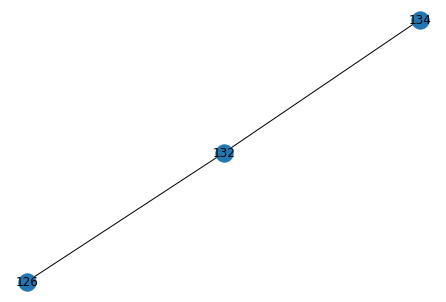

match_branches = [[126, 134]]
edges_to_delete (resolve crossover) = [[126, 132], [132, 134]]
edges_to_create (resolve crossover) = [[126, 134]]
edges_to_delete (cut_limb_network) = [array([126, 132]), array([132, 134])]
edges_to_create = [[126, 134]]
Number of connected components = 5
Comp 0 = {0, 1, 5, 6, 7, 8, 9, 10, 11, 13, 15, 17, 18, 19, 20, 22, 23, 24, 26, 27, 28, 29, 30, 31, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 98, 99, 100, 101, 104, 105, 107, 108, 109, 110, 112, 113, 114, 115, 116, 119, 120, 121, 122, 123, 124, 125, 127, 128, 129, 130, 131, 132, 135, 136, 139, 140, 141, 142, 144, 145, 146, 147, 148, 149, 150, 151, 152, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 186, 187, 

-----------counter = 0------------
 Cut iteration 1
Total number of graphs at the end of the split BEFORE DIRECTIONAL = 5
Total number of graphs at the end of the split AFTER DIRECTIONAL = 5
No valid path so moving onto the next connection


---- working on disconnecting 110 and 142
---- This disconnects S0_2 from S0_0  
 Cut iteration 0
Total number of graphs at the end of the split BEFORE DIRECTIONAL = 5
Total number of graphs at the end of the split AFTER DIRECTIONAL = 5
Shortest path = [110, 116, 122, 140, 147, 170, 172, 188, 193, 235, 241, 240, 234, 162, 142]

 --------- START OF GET BEST EDGE --------- 
curr_limb.deleted_edges=[array([12, 14]), array([12, 16]), array([12, 17]), array([14, 17]), array([16, 17]), array([126, 132]), array([132, 134])]
consider_path_neighbors_for_removal is set so segments_to_consider = [104 108 109 116 122 123 139 140 147 150 161 162 170 172 188 189 192 193
 232 233 234 235 236 239 240 241 245]
Short segments to combine = [245]


-------- Removing S

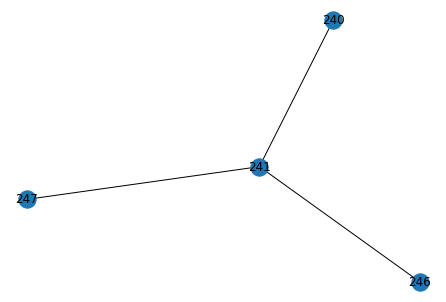

match_branches = [[241, 247], [240, 246]]
edges_to_delete (resolve crossover) = [[240, 241], [240, 247], [241, 246], [246, 247]]
edges_to_create (resolve crossover) = [[241, 247], [240, 246]]
curr_limb.deleted_edges 5 =[array([12, 14]), array([12, 16]), array([12, 17]), array([14, 17]), array([16, 17]), array([126, 132]), array([132, 134])]
NOT USING the resolve crossover delete edges because not help resolve the cut
skip_nodes = []

Attempting the doubling back check (symmetrical so don't need to check from both sides)


  Edge: [110 116]: curr_angle = 62.45
  Edge: [116 122]: curr_angle = 37.78
  Edge: [122 140]: curr_angle = 42.44
  Edge: [140 147]: curr_angle = 9.46
  Edge: [147 170]: curr_angle = 2.03
  Edge: [170 172]: curr_angle = 81.23
  Edge: [172 188]: curr_angle = 21.05
  Edge: [188 193]: curr_angle = 17.99
  Edge: [193 235]: curr_angle = 37.7
  Edge: [235 241]: curr_angle = 16.45
  Edge: [241 240]: curr_angle = 123.04
  Edge: [240 234]: curr_angle = 33.48
  Edge: [234 162]: curr_angle = 24.27
  Edge: [162 142]: curr_angle = 24.6

Total time for doubling_back = 1.2949087619781494
There were 2 edges that passed doubling back threshold of 80
Winning edge [241 240] had a doubling back of 123.0444192048337
***inside resolve crossover!!!!****
coordinate_branches = [240, 241, 246, 247]
240 = red
241 = aqua
246 = purple
247 = green
Angle between 240 and 241 = 123.56 
Angle between 240 and 246 = 41.08 
Angle between 240 and 247 = 42.43 
Angle between 241 and 246 = 24.18 
Angle between 241 and 247 = 1

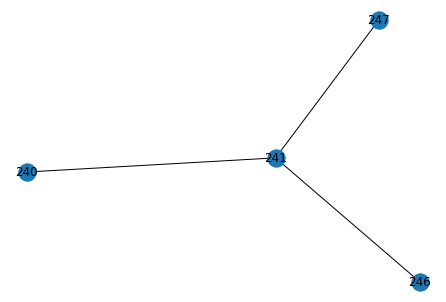

match_branches = [[241, 247]]
edges_to_delete (resolve crossover) = [[240, 241], [240, 246], [240, 247], [241, 246], [246, 247]]
edges_to_create (resolve crossover) = [[241, 247]]
edges_to_delete (cut_limb_network) = [array([240, 241]), array([240, 246]), array([240, 247]), array([241, 246]), array([246, 247])]
edges_to_create = [[241, 247]]
Number of connected components = 8
Comp 0 = {0, 1, 5, 6, 7, 8, 9, 10, 11, 13, 15, 17, 18, 19, 20, 22, 23, 24, 26, 27, 28, 29, 30, 31, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 98, 99, 100, 101, 104, 105, 107, 108, 109, 110, 112, 113, 114, 115, 116, 119, 120, 121, 122, 123, 124, 125, 127, 128, 129, 130, 131, 132, 135, 136, 139, 140, 141, 144, 145, 146, 147, 148, 149, 150, 151, 152, 154, 155, 156, 157, 158, 159, 160, 163, 164, 165, 168, 169, 17

-----------counter = 0------------
 Cut iteration 1
Total number of graphs at the end of the split BEFORE DIRECTIONAL = 8
Total number of graphs at the end of the split AFTER DIRECTIONAL = 8
No valid path so moving onto the next connection


---- working on disconnecting 118 and 133
---- This disconnects S0_1 from S0_3  
 Cut iteration 0
Total number of graphs at the end of the split BEFORE DIRECTIONAL = 8
Total number of graphs at the end of the split AFTER DIRECTIONAL = 8
No valid path so moving onto the next connection


---- working on disconnecting 118 and 142
---- This disconnects S0_1 from S0_0  
 Cut iteration 0
Total number of graphs at the end of the split BEFORE DIRECTIONAL = 8
Total number of graphs at the end of the split AFTER DIRECTIONAL = 8
No valid path so moving onto the next connection


---- working on disconnecting 133 and 142
---- This disconnects S0_3 from S0_0  
 Cut iteration 0
Total number of graphs at the end of the split BEFORE DIRECTIONAL = 8
Total number o

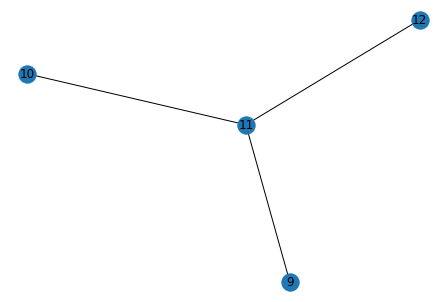

match_branches = []
edges_to_delete (resolve crossover) = [[9, 10], [9, 11], [9, 12], [10, 11], [10, 12], [11, 12]]
edges_to_create (resolve crossover) = []
curr_limb.deleted_edges 5 =[]
NOT USING the resolve crossover delete edges because not help resolve the cut
Skipping endnode 11 because skeletal distance was 469.6778333207748 and threshold was 2500
skip_nodes = [11]

Attempting the doubling back check (symmetrical so don't need to check from both sides)


  Edge: [12 14]: curr_angle = 14.13
  Edge: [14 15]: curr_angle = 18.25
  Edge: [15 20]: curr_angle = 64.74
  Edge: [20 28]: curr_angle = 116.97
  Edge: [28 17]: curr_angle = 111.4
  Edge: [17 16]: curr_angle = 36.14

Total time for doubling_back = 0.21983695030212402
There were 2 edges that passed doubling back threshold of 80
Winning edge [20 28] had a doubling back of 116.97352424706898
***inside resolve crossover!!!!****
coordinate_branches = [20, 28, 29]
20 = red
28 = aqua
29 = purple
Angle between 20 and 28 = 104.44 
Angle between 20 and 29 = 10.07 
Angle between 28 and 29 = 76.69 
Final Matches = [[20, 29]]
matched_branches_revised = [[20, 29]]
Original graph


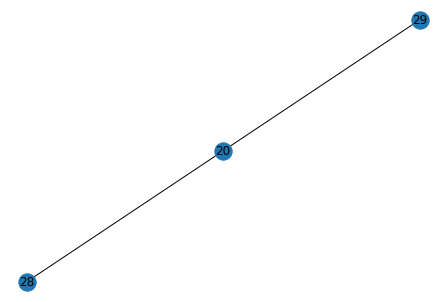

match_branches = [[20, 29]]
edges_to_delete (resolve crossover) = [[20, 28], [28, 29]]
edges_to_create (resolve crossover) = [[20, 29]]
edges_to_delete (cut_limb_network) = [array([20, 28]), array([28, 29])]
edges_to_create = [[20, 29]]
Number of connected components = 2
Comp 0 = {16, 17, 18, 21, 22, 23, 24, 25, 26, 27, 28}
Comp 1 = {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 19, 20, 29}
curr_limb_copy.deleted_edges = [array([20, 28]), array([28, 29])]
curr_limb_copy.created_edges = [[20, 29]]
After get best cut: cut_edges = [array([20, 28]), array([28, 29])], added_edges = [[20, 29]]
total_soma_paths_to_cut = []


suggested_cut_points = [[1376910.  408967.  680502.]]




-----------counter = 0------------
 Cut iteration 1
Total number of graphs at the end of the split BEFORE DIRECTIONAL = 2
Total number of graphs at the end of the split AFTER DIRECTIONAL = 2
No valid path so moving onto the next connection
Total number of graphs at the end of the split = 2: [array([16, 17, 18, 21, 22, 23, 24, 25, 26, 27, 28]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 19,
       20, 29])]


 ------ Total time for Splitting 864691135518395122 = 42.64833950996399 ------


----- Working on Neuron 864691135099874336-------
Decompressing Neuron in minimal output mode...please wait
multi_soma_limbs = []
multi_touch_limbs = []


 ------ Total time for Splitting 864691135099874336 = 33.989386320114136 ------


----- Working on Neuron 864691135945454116-------
Decompressing Neuron in minimal output mode...please wait
multi_soma_limbs = []
multi_touch_limbs = [0]


 -------- Working on limb 0------------
Starting combinations to process = [[53 65]]



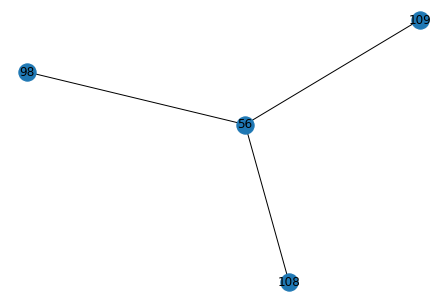

match_branches = [[98, 108], [56, 109]]
edges_to_delete (resolve crossover) = [[56, 98], [56, 108], [98, 109], [108, 109]]
edges_to_create (resolve crossover) = [[98, 108], [56, 109]]
curr_limb.deleted_edges 5 =[]
NOT USING the resolve crossover delete edges because not help resolve the cut
skip_nodes = []

Attempting the doubling back check (symmetrical so don't need to check from both sides)


  Edge: [53 54]: curr_angle = 114.59
  Edge: [54 56]: curr_angle = 96.88
  Edge: [56 98]: curr_angle = 104.34
  Edge: [98 75]: curr_angle = 76.96
  Edge: [75 65]: curr_angle = 33.5

Total time for doubling_back = 0.5064225196838379
There were 3 edges that passed doubling back threshold of 80
Winning edge [53 54] had a doubling back of 114.587122041606
***inside resolve crossover!!!!****
coordinate_branches = [50, 53, 54]
50 = red
53 = aqua
54 = purple
Angle between 50 and 53 = 12.68 
Angle between 50 and 54 = 59.99 
Angle between 53 and 54 = 110.76 
Final Matches = [[50, 53]]
matched_branches_revised = [[50, 53]]
Original graph


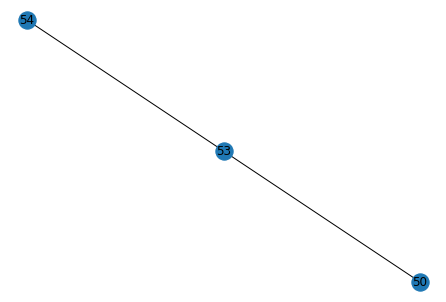

match_branches = [[50, 53]]
edges_to_delete (resolve crossover) = [[50, 54], [53, 54]]
edges_to_create (resolve crossover) = [[50, 53]]
edges_to_delete (cut_limb_network) = [array([50, 54]), array([53, 54])]
edges_to_create = [[50, 53]]
Number of connected components = 3
Comp 0 = {54, 56, 57, 58, 59, 63, 64, 65, 73, 74, 75, 77, 78, 79, 80, 81, 82, 83, 84, 85, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 106, 108, 109}
Comp 1 = {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44.0, 45, 46, 47, 48, 49, 50, 51, 52, 53, 55, 60, 61, 62, 66, 67, 68, 69, 70, 71, 72, 76, 86, 87, 88, 105, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122}
Comp 2 = {107}
curr_limb_copy.deleted_edges = [array([50, 54]), array([53, 54])]
curr_limb_copy.created_edges = [[50, 53]]
After get best cut: cut_edges = [array([50, 54]), array([53, 54])], added_edges = [

-----------counter = 0------------
 Cut iteration 1
Total number of graphs at the end of the split BEFORE DIRECTIONAL = 3
Total number of graphs at the end of the split AFTER DIRECTIONAL = 3
No valid path so moving onto the next connection
Total number of graphs at the end of the split = 3: [array([ 54,  56,  57,  58,  59,  63,  64,  65,  73,  74,  75,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  89,  90,  91,  92,  93,  94,
        95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 106, 108, 109]), array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
        44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  55.,
        60.,  61.,  62.,  66.,  67.,  68.,  69.,  70.,  71.,  72.,  76.,
        86.,  87.,  88., 105., 110., 111., 112., 11

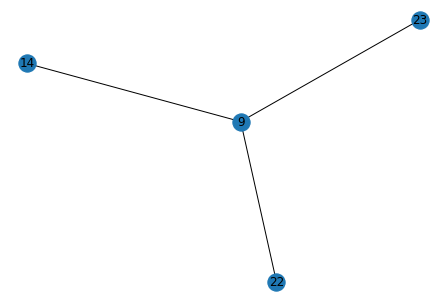

match_branches = [[9, 23], [14, 22]]
edges_to_delete (resolve crossover) = [[9, 14], [9, 22], [14, 23], [22, 23]]
edges_to_create (resolve crossover) = [[9, 23], [14, 22]]
curr_limb.deleted_edges 5 =[]
NOT USING the resolve crossover delete edges because not help resolve the cut
skip_nodes = []

Attempting the doubling back check (symmetrical so don't need to check from both sides)


  Edge: [5 6]: curr_angle = 41.33
  Edge: [6 9]: curr_angle = 56.06
  Edge: [ 9 14]: curr_angle = 95.25
  Edge: [14 17]: curr_angle = 43.06
  Edge: [17 13]: curr_angle = 26.19
  Edge: [13 11]: curr_angle = 38.31
  Edge: [11 10]: curr_angle = 10.43

Total time for doubling_back = 0.5568835735321045
There were 1 edges that passed doubling back threshold of 80
Winning edge [ 9 14] had a doubling back of 95.25137200184814
***inside resolve crossover!!!!****
coordinate_branches = [9, 14, 22, 23]
9 = red
14 = aqua
22 = purple
23 = green
Angle between 9 and 14 = 114.31 
Angle between 9 and 22 = 73.91 
Angle between 9 and 23 = 9.29 
Angle between 14 and 22 = 16.3 
Angle between 14 and 23 = 58.35 
Angle between 22 and 23 = 114.71 
Final Matches = [[9, 23], [14, 22]]
matched_branches_revised = [[9, 23], [14, 22]]
Original graph


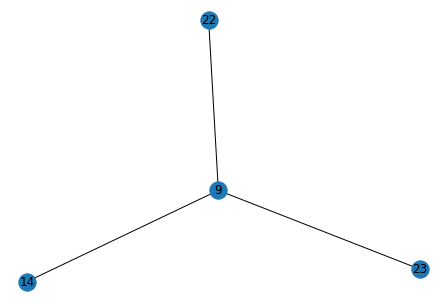

match_branches = [[9, 23], [14, 22]]
edges_to_delete (resolve crossover) = [[9, 14], [9, 22], [14, 23], [22, 23]]
edges_to_create (resolve crossover) = [[9, 23], [14, 22]]
edges_to_delete (cut_limb_network) = [array([ 9, 14]), array([ 9, 22]), array([14, 23]), array([22, 23])]
edges_to_create = [[9, 23], [14, 22]]
Number of connected components = 2
Comp 0 = {0, 1, 2, 3, 4, 5, 6, 8, 9, 15, 16, 23}
Comp 1 = {7, 10, 11, 12, 13, 14, 17, 18, 19, 20, 21, 22}
curr_limb_copy.deleted_edges = [array([ 9, 14]), array([ 9, 22]), array([14, 23]), array([22, 23])]
curr_limb_copy.created_edges = [[9, 23], [14, 22]]
After get best cut: cut_edges = [array([ 9, 14]), array([ 9, 22]), array([14, 23]), array([22, 23])], added_edges = [[9, 23], [14, 22]]
total_soma_paths_to_cut = []


suggested_cut_points = [[1388770.  636665.  890654.]]




-----------counter = 0------------
 Cut iteration 1
Total number of graphs at the end of the split BEFORE DIRECTIONAL = 2
Total number of graphs at the end of the split AFTER DIRECTIONAL = 2
No valid path so moving onto the next connection
Total number of graphs at the end of the split = 2: [array([ 0,  1,  2,  3,  4,  5,  6,  8,  9, 15, 16, 23]), array([ 7, 10, 11, 12, 13, 14, 17, 18, 19, 20, 21, 22])]


 -------- Working on limb 3------------
Starting combinations to process = [[10 12]]


---- working on disconnecting 10 and 12
---- This disconnects S0_1 from S0_0  
 Cut iteration 0
Total number of graphs at the end of the split BEFORE DIRECTIONAL = 1
Total number of graphs at the end of the split AFTER DIRECTIONAL = 1
Shortest path = [10, 9, 8, 11, 12]

 --------- START OF GET BEST EDGE --------- 
curr_limb.deleted_edges=[]
consider_path_neighbors_for_removal is set so segments_to_consider = [ 0  2  3  7  8  9 11]
Short segments to combine = [7]


-------- Removing Segments --------

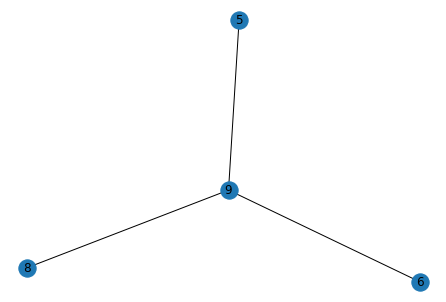

match_branches = [[6, 8], [5, 9]]
edges_to_delete (resolve crossover) = [[5, 6], [5, 8], [6, 9], [8, 9]]
edges_to_create (resolve crossover) = [[6, 8], [5, 9]]
curr_limb.deleted_edges 5 =[]
NOT USING the resolve crossover delete edges because not help resolve the cut
skip_nodes = []

Attempting the doubling back check (symmetrical so don't need to check from both sides)


  Edge: [10  9]: curr_angle = 17.29
  Edge: [9 8]: curr_angle = 136.3
  Edge: [ 8 11]: curr_angle = 36.69
  Edge: [11 12]: curr_angle = 29.55

Total time for doubling_back = 0.3637712001800537
There were 1 edges that passed doubling back threshold of 80
Winning edge [9 8] had a doubling back of 136.2965230684155
***inside resolve crossover!!!!****
coordinate_branches = [5, 6, 8, 9]
5 = red
6 = aqua
8 = purple
9 = green
Angle between 5 and 6 = 124.74 
Angle between 5 and 8 = 32.76 
Angle between 5 and 9 = 40.24 
Angle between 6 and 8 = 28.07 
Angle between 6 and 9 = 65.4 
Angle between 8 and 9 = 118.9 
Final Matches = [[5, 8], [6, 8]]
matched_branches_revised = [[6, 8]]
Original graph


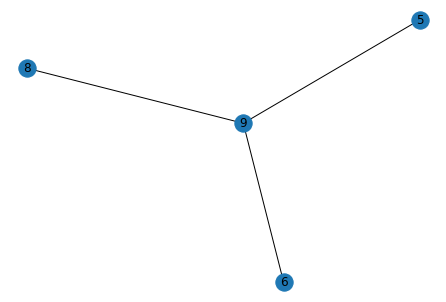

match_branches = [[6, 8]]
edges_to_delete (resolve crossover) = [[5, 6], [5, 8], [5, 9], [6, 9], [8, 9]]
edges_to_create (resolve crossover) = [[6, 8]]
edges_to_delete (cut_limb_network) = [array([5, 6]), array([5, 8]), array([5, 9]), array([6, 9]), array([8, 9])]
edges_to_create = [[6, 8]]
Number of connected components = 4
Comp 0 = {0, 2, 6, 8, 11, 12}
Comp 1 = {1, 4, 5}
Comp 2 = {9, 10, 3}
Comp 3 = {7}
curr_limb_copy.deleted_edges = [array([5, 6]), array([5, 8]), array([5, 9]), array([6, 9]), array([8, 9])]
curr_limb_copy.created_edges = [[6, 8]]
After get best cut: cut_edges = [array([5, 6]), array([5, 8]), array([5, 9]), array([6, 9]), array([8, 9])], added_edges = [[6, 8]]
total_soma_paths_to_cut = []


suggested_cut_points = [[1319408.26320193  617219.72938796  703060.7887084 ]]




-----------counter = 0------------
 Cut iteration 1
Total number of graphs at the end of the split BEFORE DIRECTIONAL = 4
Total number of graphs at the end of the split AFTER DIRECTIONAL = 4
No valid path so moving onto the next connection
Total number of graphs at the end of the split = 4: [array([ 0,  2,  6,  8, 11, 12]), array([1, 4, 5]), array([ 9, 10,  3]), array([7])]


 ------ Total time for Splitting 864691135474658368 = 93.38321685791016 ------


----- Working on Neuron 864691135303196071-------
Decompressing Neuron in minimal output mode...please wait
multi_soma_limbs = []
multi_touch_limbs = []


 ------ Total time for Splitting 864691135303196071 = 18.35332202911377 ------


----- Working on Neuron 864691135501548866-------
Decompressing Neuron in minimal output mode...please wait
multi_soma_limbs = []
multi_touch_limbs = [3]


 -------- Working on limb 3------------
Starting combinations to process = [[7 8]]


---- working on disconnecting 7 and 8
---- This disconnects S0_

  Edge: [7 6]: curr_angle = 63.86
  Edge: [6 8]: curr_angle = 116.53

Total time for doubling_back = 0.0479276180267334
There were 1 edges that passed doubling back threshold of 80
Winning edge [6 8] had a doubling back of 116.52561612838215
***inside resolve crossover!!!!****
coordinate_branches = [5, 6, 8]
5 = red
6 = aqua
8 = purple
Angle between 5 and 6 = 36.22 
Angle between 5 and 8 = 86.7 
Angle between 6 and 8 = 74.57 
Final Matches = []
matched_branches_revised = []
Original graph


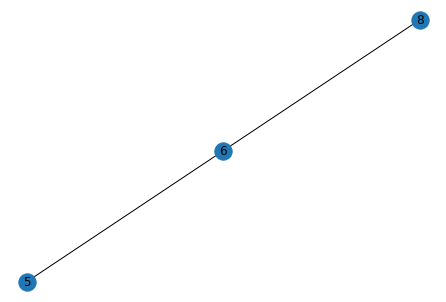

match_branches = []
edges_to_delete (resolve crossover) = [[5, 6], [5, 8], [6, 8]]
edges_to_create (resolve crossover) = []
edges_to_delete (cut_limb_network) = [array([5, 6]), array([5, 8]), array([6, 8])]
edges_to_create = []
Number of connected components = 3
Comp 0 = {8}
Comp 1 = {5}
Comp 2 = {0, 1, 2, 3, 4, 6, 7}
curr_limb_copy.deleted_edges = [array([5, 6]), array([5, 8]), array([6, 8])]
curr_limb_copy.created_edges = []
After get best cut: cut_edges = [array([5, 6]), array([5, 8]), array([6, 8])], added_edges = []
total_soma_paths_to_cut = []


suggested_cut_points = [[1346859.56022013  776807.34755105  830426.58514704]]




-----------counter = 0------------
 Cut iteration 1
Total number of graphs at the end of the split BEFORE DIRECTIONAL = 3
Total number of graphs at the end of the split AFTER DIRECTIONAL = 3
No valid path so moving onto the next connection
Total number of graphs at the end of the split = 3: [array([8]), array([5]), array([0, 1, 2, 3, 4, 6, 7])]


 ------ Total time for Splitting 864691135501548866 = 14.393541812896729 ------


----- Working on Neuron 864691135210028992-------
Decompressing Neuron in minimal output mode...please wait
multi_soma_limbs = []
multi_touch_limbs = []


 ------ Total time for Splitting 864691135210028992 = 23.488850593566895 ------


----- Working on Neuron 864691135855610670-------
Decompressing Neuron in minimal output mode...please wait
multi_soma_limbs = []
multi_touch_limbs = []


 ------ Total time for Splitting 864691135855610670 = 46.77518391609192 ------


----- Working on Neuron 864691135861174625-------
Decompressing Neuron in minimal output mode...

  Edge: [3 2]: curr_angle = 39.42
  Edge: [2 5]: curr_angle = 28.22

Total time for doubling_back = 0.2879507541656494

Attempting the width jump check (ARTIFICIALLY ATTEMPTING FROM BOTH SIDES)
width_jump_threshold = 200
  Edge: [3 2]: jump = 216.14
Adding error edge [3 2] because width jump was 216.13733358305785
  Edge: [2 5]: jump = -40.39
Total time for width = 0.2643427848815918
Did not find an error edge in either of the paths
Number of connected components = 1
Comp 0 = {0, 1, 2, 3, 4, 5, 6}
curr_limb_copy.deleted_edges = []
curr_limb_copy.created_edges = []
After get best cut: cut_edges = None, added_edges = []
***** there was no suggested cut for this limb even though it is still connnected***


---- working on disconnecting 3 and 6
---- This disconnects S0_0 from S1_1  
 Cut iteration 0
Total number of graphs at the end of the split BEFORE DIRECTIONAL = 1
Total number of graphs at the end of the split AFTER DIRECTIONAL = 1
Shortest path = [3, 2, 6]

 --------- START OF GET BES

  Edge: [3 2]: curr_angle = 39.42

Total time for doubling_back = 0.1773056983947754

Attempting the width jump check (ARTIFICIALLY ATTEMPTING FROM BOTH SIDES)
width_jump_threshold = 200
  Edge: [3 2]: jump = 216.14
Adding error edge [3 2] because width jump was 216.13733358305785
Total time for width = 0.14443731307983398
Did not find an error edge in either of the paths
Number of connected components = 1
Comp 0 = {0, 1, 2, 3, 4, 5, 6}
curr_limb_copy.deleted_edges = []
curr_limb_copy.created_edges = []
After get best cut: cut_edges = None, added_edges = []
***** there was no suggested cut for this limb even though it is still connnected***


---- working on disconnecting 5 and 6
---- This disconnects S1_0 from S1_1  
 Cut iteration 0
Total number of graphs at the end of the split BEFORE DIRECTIONAL = 1
Total number of graphs at the end of the split AFTER DIRECTIONAL = 1
Shortest path = [5, 6]

 --------- START OF GET BEST EDGE --------- 
curr_limb.deleted_edges=[]
consider_path_neighb

  Edge: [5 6]: curr_angle = 109.52

Total time for doubling_back = 0.0391542911529541
There were 1 edges that passed doubling back threshold of 80
Winning edge [5 6] had a doubling back of 109.52423430740184
***inside resolve crossover!!!!****
coordinate_branches = [2, 5, 6]
2 = red
5 = aqua
6 = purple
Angle between 2 and 5 = 20.46 
Angle between 2 and 6 = 83.49 
Angle between 5 and 6 = 110.11 
Final Matches = [[2, 5]]
matched_branches_revised = [[2, 5]]
Original graph


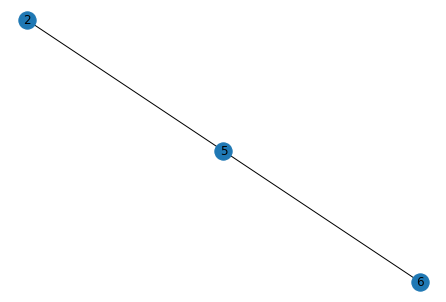

match_branches = [[2, 5]]
edges_to_delete (resolve crossover) = [[2, 6], [5, 6]]
edges_to_create (resolve crossover) = [[2, 5]]
edges_to_delete (cut_limb_network) = [array([2, 6]), array([5, 6])]
edges_to_create = [[2, 5]]
Number of connected components = 2
Comp 0 = {0, 1, 2, 3, 4, 5}
Comp 1 = {6}
curr_limb_copy.deleted_edges = [array([2, 6]), array([5, 6])]
curr_limb_copy.created_edges = [[2, 5]]
After get best cut: cut_edges = [array([2, 6]), array([5, 6])], added_edges = [[2, 5]]
total_soma_paths_to_cut = []


suggested_cut_points = [[1349973.70972717 1028617.67686514  965275.87238944]]




-----------counter = 0------------
 Cut iteration 1
Total number of graphs at the end of the split BEFORE DIRECTIONAL = 2
Total number of graphs at the end of the split AFTER DIRECTIONAL = 2
No valid path so moving onto the next connection
Total number of graphs at the end of the split = 2: [array([0, 1, 2, 3, 4, 5]), array([6])]


 -------- Working on limb 4------------
Starting combinations to process = [[0 1]
 [0 2]
 [1 2]]


---- working on disconnecting 0 and 1
---- This disconnects S0_2 from S0_0  
 Cut iteration 0
Total number of graphs at the end of the split BEFORE DIRECTIONAL = 1
Total number of graphs at the end of the split AFTER DIRECTIONAL = 1
Shortest path = [0, 1]

 --------- START OF GET BEST EDGE --------- 
curr_limb.deleted_edges=[]
consider_path_neighbors_for_removal is set so segments_to_consider = [3]
Short segments to combine = []
Found 1 high degree coordinates to cut
Picking [1369509.49503271 1097601.03930738  965270.62394277] high degree coordinates to cut
cur

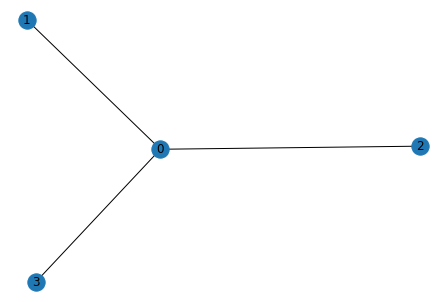

match_branches = []
edges_to_delete (resolve crossover) = [[0, 1], [0, 2], [0, 3], [1, 2], [1, 3], [2, 3]]
edges_to_create (resolve crossover) = []
curr_limb.deleted_edges 5 =[]
NOT USING the resolve crossover delete edges because not help resolve the cut
Skipping endnode 0 because skeletal distance was 2382.8816766311857 and threshold was 2500
Could not used the revised endnodes path because empty
skip_nodes = []

Attempting the doubling back check (symmetrical so don't need to check from both sides)


  Edge: [0 1]: curr_angle = 130.81

Total time for doubling_back = 0.030440330505371094
There were 1 edges that passed doubling back threshold of 80
Winning edge [0 1] had a doubling back of 130.81011928926935
***inside resolve crossover!!!!****
coordinate_branches = [0, 1, 2, 3]
0 = red
1 = aqua
2 = purple
3 = green
Angle between 0 and 1 = 130.81 
Angle between 0 and 2 = 111.11 
Angle between 0 and 3 = 56.39 
Angle between 1 and 2 = 87.86 
Angle between 1 and 3 = 95.37 
Angle between 2 and 3 = 24.26 
Final Matches = [[2, 3]]
matched_branches_revised = [[2, 3]]
Original graph


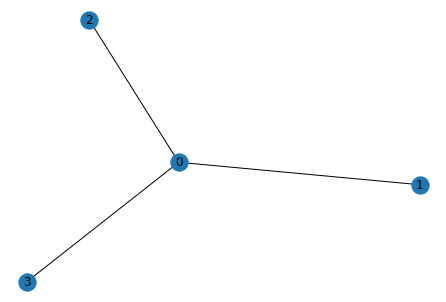

match_branches = [[2, 3]]
edges_to_delete (resolve crossover) = [[0, 1], [0, 2], [0, 3], [1, 2], [1, 3]]
edges_to_create (resolve crossover) = [[2, 3]]
Rejecting creating edge [2, 3] becuase did not involve only 1 node in the deleted edge
edges_to_delete (cut_limb_network) = [array([0, 1]), array([0, 2]), array([0, 3]), array([1, 2]), array([1, 3])]
edges_to_create = []
Number of connected components = 4
Comp 0 = {1}
Comp 1 = {0}
Comp 2 = {2}
Comp 3 = {3}
curr_limb_copy.deleted_edges = [array([0, 1]), array([0, 2]), array([0, 3]), array([1, 2]), array([1, 3])]
curr_limb_copy.created_edges = []
After get best cut: cut_edges = [array([0, 1]), array([0, 2]), array([0, 3]), array([1, 2]), array([1, 3])], added_edges = []
total_soma_paths_to_cut = []


suggested_cut_points = [[1369509.49503271 1097601.03930738  965270.62394277]]




-----------counter = 0------------
 Cut iteration 1
Total number of graphs at the end of the split BEFORE DIRECTIONAL = 4
Total number of graphs at the end of the split AFTER DIRECTIONAL = 4
No valid path so moving onto the next connection


---- working on disconnecting 0 and 2
---- This disconnects S0_2 from S0_3  
 Cut iteration 0
Total number of graphs at the end of the split BEFORE DIRECTIONAL = 4
Total number of graphs at the end of the split AFTER DIRECTIONAL = 4
No valid path so moving onto the next connection


---- working on disconnecting 1 and 2
---- This disconnects S0_0 from S0_3  
 Cut iteration 0
Total number of graphs at the end of the split BEFORE DIRECTIONAL = 4
Total number of graphs at the end of the split AFTER DIRECTIONAL = 4
No valid path so moving onto the next connection
Total number of graphs at the end of the split = 4: [array([1]), array([0]), array([2]), array([3])]


 ------ Total time for Splitting 864691135861174625 = 13.76500391960144 ------


----- Wo

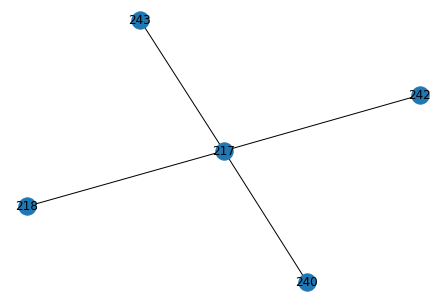

match_branches = [[218, 240]]
edges_to_delete (resolve crossover) = [[217, 218], [217, 240], [217, 242], [217, 243], [218, 242], [218, 243], [240, 242], [240, 243], [242, 243]]
edges_to_create (resolve crossover) = [[218, 240]]
curr_limb.deleted_edges 5 =[]
NOT USING the resolve crossover delete edges because not help resolve the cut
skip_nodes = []

Attempting the doubling back check (symmetrical so don't need to check from both sides)


  Edge: [213 163]: curr_angle = 46.17
  Edge: [163 195]: curr_angle = 23.46
  Edge: [195 182]: curr_angle = 29.19
  Edge: [182 148]: curr_angle = 74.71
  Edge: [148  94]: curr_angle = 61.73
  Edge: [94 90]: curr_angle = 23.52
  Edge: [90 71]: curr_angle = 14.77
  Edge: [71 72]: curr_angle = 36.01
  Edge: [72 68]: curr_angle = 14.13
  Edge: [68 58]: curr_angle = 18.15
  Edge: [58 89]: curr_angle = 12.29
  Edge: [ 89 100]: curr_angle = 12.64
  Edge: [100 217]: curr_angle = 15.45
  Edge: [217 218]: curr_angle = 99.99
  Edge: [218 214]: curr_angle = 62.38

Total time for doubling_back = 1.5447864532470703
There were 1 edges that passed doubling back threshold of 80
Winning edge [217 218] had a doubling back of 99.98957431541037
***inside resolve crossover!!!!****
coordinate_branches = [217, 218, 240, 242, 243]
217 = red
218 = aqua
240 = purple
242 = green
Angle between 217 and 218 = 108.04 
Angle between 217 and 240 = 73.78 
Angle between 217 and 242 = 118.75 
Angle between 217 and 243 = 4

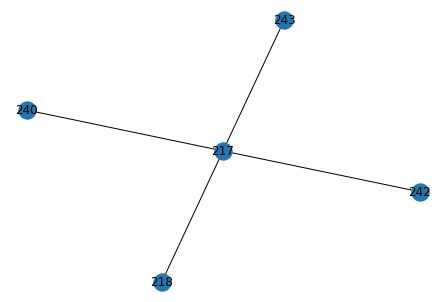

match_branches = []
edges_to_delete (resolve crossover) = [[217, 218], [217, 240], [217, 242], [217, 243], [218, 240], [218, 242], [218, 243], [240, 242], [240, 243], [242, 243]]
edges_to_create (resolve crossover) = []
edges_to_delete (cut_limb_network) = [array([217, 218]), array([217, 240]), array([217, 242]), array([217, 243]), array([218, 240]), array([218, 242]), array([218, 243]), array([240, 242]), array([240, 243]), array([242, 243])]
edges_to_create = []
Number of connected components = 6
Comp 0 = {225, 232, 299, 268, 300, 214, 218, 251, 220}
Comp 1 = {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 1

-----------counter = 0------------
 Cut iteration 1
Total number of graphs at the end of the split BEFORE DIRECTIONAL = 6
Total number of graphs at the end of the split AFTER DIRECTIONAL = 6
No valid path so moving onto the next connection
Total number of graphs at the end of the split = 6: [array([225, 232, 299, 268, 300, 214, 218, 251, 220]), array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
     

In [11]:
start_time = time.time()
if not test_mode:
    time.sleep(random.randint(0, 800))
print('Populate Started')
if not test_mode:
    NeuronSplitSuggestions.populate(reserve_jobs=True, suppress_errors=True)
else:
    NeuronSplitSuggestions.populate(reserve_jobs=True, suppress_errors=True)
print('Populate Done')

print(f"Total time for NeuronSplitSuggestions populate = {time.time() - start_time}")

In [12]:
# import proofreading_utils as pru
# pru = reload(pru)
# du.create_suggested_splits_neuroglancer_spreadsheet(output_type="local")